# 使用自动编码器进行特征工程

In [1]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

import pandas as pd
import numpy as np
import tensorflow as tf

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

d:\ProgramData\Anaconda3\lib\site-packages\h5py\__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [44]:
Y_Standard = True
# 生成的结果文件编号
out_name = '%s%s-encoder=%s.csv'

# path  = '../data/new/'
path_train = '../data/new/train=0.1/'
path_test = '../data/new/test/'
summit_path = '../data/summit/'

In [3]:
train_part1 = pd.read_csv(path_train + 'train=0.1-fe.csv')
train_part1.head()

,user_id,register_time,wood_add_value,wood_reduce_value,stone_add_value,stone_reduce_value,ivory_add_value,ivory_reduce_value,meat_add_value,meat_reduce_value,...,pvp_battle_count,pvp_lanch_count,pvp_win_count,pve_battle_count,pve_lanch_count,pve_win_count,avg_online_minutes,pay_price,pay_count,prediction_pay_price
0,2320186,124,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,3.833333,0.0,0,0.0
1,2959017,121,129429,78242,0,0,6000,0,152480,48626,...,0,0,0,2,2,2,3.166667,0.0,0,0.0
2,242613,122,84839,52467,0,0,0,0,22144,29600,...,0,0,0,0,0,0,2.666667,0.0,0,0.0
3,1416097,136,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0.333333,0.0,0,0.0
4,680469,104,28625,7200,0,0,0,0,33625,3930,...,0,0,0,0,0,0,1.000000,0.0,0,0.0


In [4]:
test_df = pd.read_csv(path_test + 'tap_fun_test-fe.csv')
test_df.head()

,user_id,register_time,wood_add_value,wood_reduce_value,stone_add_value,stone_reduce_value,ivory_add_value,ivory_reduce_value,meat_add_value,meat_reduce_value,...,sr_rss_help_bonus_level,pvp_battle_count,pvp_lanch_count,pvp_win_count,pve_battle_count,pve_lanch_count,pve_win_count,avg_online_minutes,pay_price,pay_count
0,14933,94,166415.0,138362.0,0,0,0,0,258522,90142,...,0,0,0,0,1,1,1,8.000000,0.0,0
1,14934,94,10000.0,600.0,0,0,0,0,10000,400,...,0,0,0,0,0,0,0,0.166667,0.0,0
2,14935,94,10000.0,3700.0,0,0,0,0,10000,2000,...,0,0,0,0,0,0,0,17.000000,0.0,0
3,14936,94,210000.0,0.0,200000,0,200000,0,610000,0,...,0,0,0,0,0,0,0,1.666667,0.0,0
4,14937,94,11500.0,3700.0,0,0,0,0,11000,2000,...,0,0,0,0,0,0,0,0.333333,0.0,0


In [48]:
# 从原始数据中分离输入特征x和输出y
target = 'prediction_pay_price'
id = 'user_id'
train_y = train_part1[target].values
train_X = train_part1.drop([target, id], axis = 1)

# test_id = test[id]
test_X = test_df.drop([id], axis = 1)

In [49]:
X_train_part, X_val_part, y_train_part, y_val_part = train_test_split(train_X, train_y, random_state=33, test_size=0.1)
print('train.shape=%s X_train_part.shape=%s X_val_part.shape=%s'
      %(train_part1.shape, X_train_part.shape, X_val_part.shape))

train.shape=(228800, 109) X_train_part.shape=(205920, 107) X_val_part.shape=(22880, 107)


## 2 数据标准化

In [50]:
# 分别初始化对特征和目标值的标准化器
ss_X = StandardScaler()
ss_y = StandardScaler()

# 分别对训练和测试数据的特征以及目标值进行标准化处理
X_train_part = ss_X.fit_transform(X_train_part)
X_val_part = ss_X.transform(X_val_part)
test_X_ss = ss_X.transform(test_X)
train_X_ss = ss_X.transform(train_X)

if Y_Standard:
    y_train_part = ss_y.fit_transform(y_train_part.reshape(-1, 1))
    y_val_part = ss_y.transform(y_val_part.reshape(-1, 1))

In [8]:
# 标准化数据还原 
def inverse_StandardScaler(predict):
    if Y_Standard:
        predict = ss_y.inverse_transform(predict)
        print('predict = ', predict)
    return predict

#输出预测后的数据
def generate_summit(predict):
    testPredict = test_df.copy()
    testPredict[[id] + train_X.columns.values] = predict
    testPredict = testPredict[[id,target]]
    testPredict[target] = testPredict[target].apply(lambda x: x if x > 0 else 0)
    return testPredict

## 3. 训练模型

In [9]:
# 设置全局变量的参数
learning_rate = 0.01
num_steps = 2000
batch_size = 128

# 显示步数
n_sample = X_train_part.shape[0]
display_step = 100 #500
examples_to_show = 1 #10

# 设置网络参数
num_hidden_1 = 64 # 1st layer num features
# num_hidden_2 = 32 # 2nd layer num features (the latent dim)
num_hidden_2 = 16 # 2nd layer num features (the latent dim)
num_input = 107 # MNIST data input (img shape: 28*28)

In [10]:
# 设置输入占位符
X = tf.placeholder("float", [None, num_input])

# 设置网络层的参数
weights = {
    "encoder_h1":tf.Variable(tf.random_normal([num_input, num_hidden_1])),
    "encoder_h2":tf.Variable(tf.random_normal([num_hidden_1, num_hidden_2])),
    "decoder_h1":tf.Variable(tf.random_normal([num_hidden_2, num_hidden_1])),
    "decoder_h2":tf.Variable(tf.random_normal([num_hidden_1, num_input])),
}
biases = {
    "encoder_b1":tf.Variable(tf.random_normal([num_hidden_1])),
    "encoder_b2":tf.Variable(tf.random_normal([num_hidden_2])),
    "decoder_b1":tf.Variable(tf.random_normal([num_hidden_1])),
    "decoder_b2":tf.Variable(tf.random_normal([num_input])),
}

In [11]:
# build解码和编码层,使用sigmoid的激活函数
def encoder(x, activate_func):
    layer_1 = activate_func(tf.add(tf.matmul(x, weights['encoder_h1']), biases['encoder_b1']))
    layer_2 = activate_func(tf.add(tf.matmul(layer_1, weights['encoder_h2']), biases['encoder_b2']))
    return layer_2
def decoder(x, activate_func):
    layer_1 = activate_func(tf.add(tf.matmul(x, weights['decoder_h1']), biases['decoder_b1']))
    layer_2 = activate_func(tf.add(tf.matmul(layer_1, weights['decoder_h2']), biases['decoder_b2']))
    return layer_2

In [12]:
# 构造model
activate_func = tf.nn.sigmoid
encoder_op = encoder(X, activate_func)
decoder_op = decoder(encoder_op, activate_func)

y_pre = decoder_op
y = X

# 使用平方误差进行优化
# loss = tf.reduce_sum(tf.pow(y-y_pre, 2)) 
# optimizer = tf.train.RMSPropOptimizer(learning_rate=learning_rate).minimize(loss)
loss = tf.losses.mean_squared_error(y, y_pre)   # compute cost 损失函数
optimizer = tf.train.AdamOptimizer(learning_rate=0.001).minimize(loss)

In [18]:
# 进行训练
sess = tf.Session()
sess.run(tf.global_variables_initializer())  

for step in range(0, num_steps):
    i_from = step * batch_size
    i_to = (step+1) * batch_size
    if i_to > (n_sample - 1): #索引越界处理 
        i_to = (n_sample - 1)
    _, l = sess.run([optimizer, loss], feed_dict={X:X_train_part[i_from:i_to]})
    if step % display_step == 0:
        print ("Step=%d: loss=%f" % (step, l))

Step=0: loss=1.482927
Step=100: loss=0.951285
Step=200: loss=0.574418
Step=300: loss=0.537969
Step=400: loss=0.278575
Step=500: loss=0.231899
Step=600: loss=0.822724
Step=700: loss=0.230051
Step=800: loss=0.291198
Step=900: loss=0.222174
Step=1000: loss=0.604805
Step=1100: loss=0.310612
Step=1200: loss=1.348877
Step=1300: loss=0.261172
Step=1400: loss=0.379181
Step=1500: loss=0.477849
Step=1600: loss=0.174576
Step=1700: loss=0.000000
Step=1800: loss=0.000000
Step=1900: loss=0.000000


In [14]:
def plot_x(x_origin, x_decoder):
    plt.figure(figsize=(18, 6))
    x = np.arange(0, len(x_origin[0]), 1)
    plt.plot(x, x_origin[0], '-o', label='origin')
    plt.plot(x, x_decoder[0], '-o', label='Reconstructed')

    plt.xlabel('dimession')
    plt.ylabel('value')
    plt.legend()
    plt.show()

i=0
x_encoder=[[9.9732697e-01 9.9991882e-01 9.4977999e-03 9.9982530e-01 9.9756217e-01
  9.9405020e-01 8.5718483e-01 4.1624886e-01 9.9866128e-01 3.5881770e-03
  5.9540772e-01 9.8150587e-01 3.7732988e-04 2.5285122e-03 9.9997056e-01
  9.9856454e-01]]


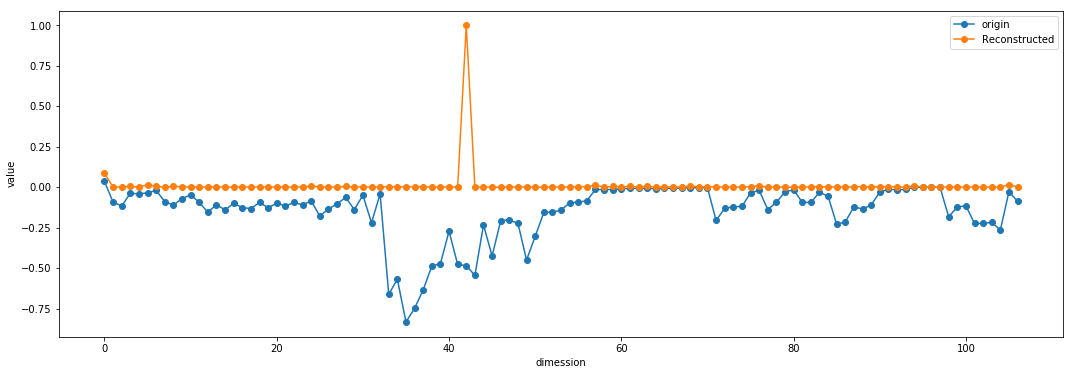

i=1
x_encoder=[[0.9938294  0.99894935 0.01060815 0.9885992  0.9489484  0.9963154
  0.9966363  0.99096596 0.9943532  0.00538025 0.57449234 0.9640999
  0.00306798 0.01059367 0.9999367  0.99530596]]


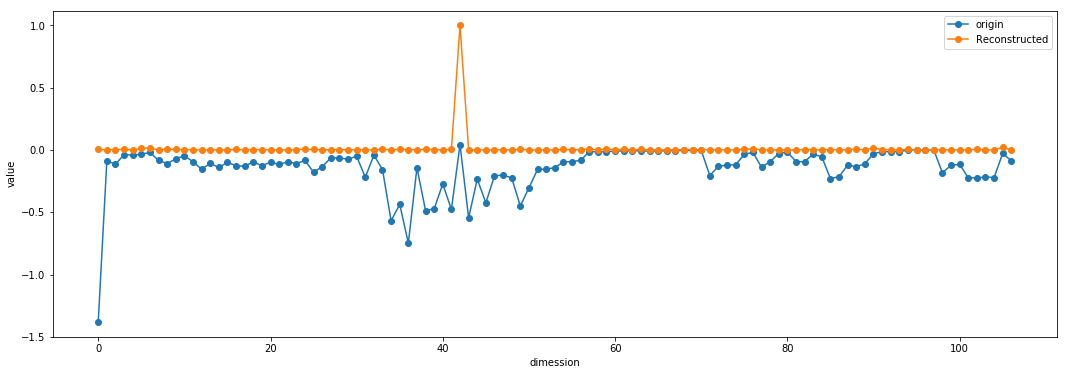

i=2
x_encoder=[[9.9906164e-01 9.9987972e-01 3.1185998e-03 9.9989951e-01 9.9861920e-01
  9.9380589e-01 2.7530602e-01 1.1471458e-02 9.9986160e-01 1.2601895e-02
  2.3737161e-01 9.7320503e-01 3.3728866e-04 1.0579889e-02 9.9998605e-01
  9.9576002e-01]]


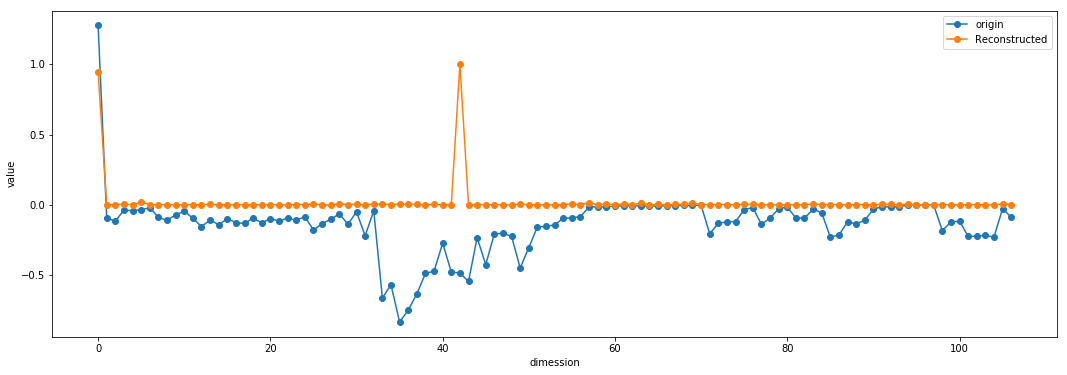

i=3
x_encoder=[[0.9969311  0.9994235  0.13945988 0.9187241  0.9313058  0.9926892
  0.9915304  0.981699   0.9734658  0.02778619 0.15944526 0.99296075
  0.011264   0.07765482 0.99999046 0.9866303 ]]


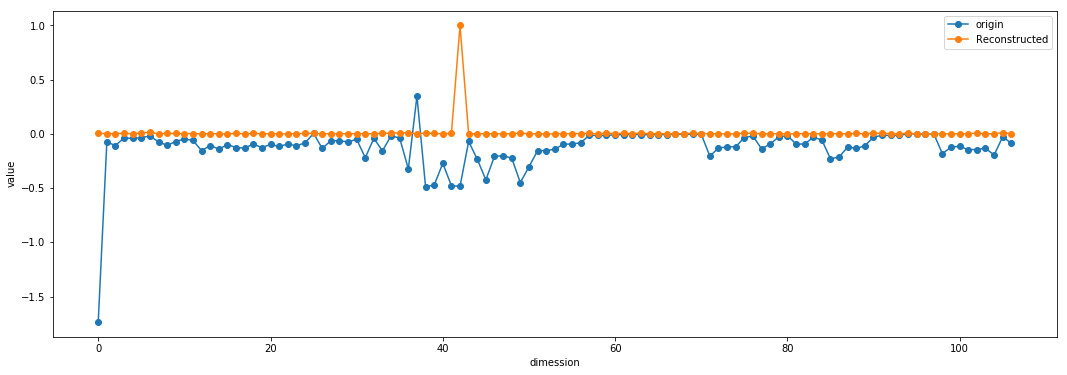

i=4
x_encoder=[[9.48688030e-01 1.48314640e-01 9.18589115e-01 5.78948902e-03
  4.74346383e-03 6.61402822e-01 9.49598849e-02 8.38817446e-04
  8.19977760e-01 9.96110260e-01 1.06924155e-04 9.48761008e-04
  9.99268830e-01 9.97791767e-01 1.00000000e+00 2.16296837e-01]]


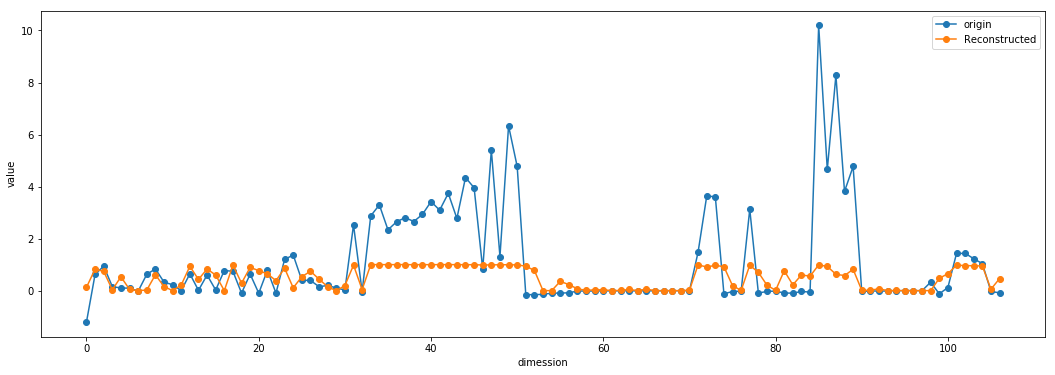

In [21]:
n = 5
for i in range(n):
    print('i=%d'%i)
    x_origin = X_val_part[i:i+1]
#     x_origin = X_train_part[i:i+1]
#     print('x_origin=%s'% x_origin)
    x_encoder, x_decoder = sess.run([encoder_op, decoder_op], feed_dict={X: x_origin})
    print('x_encoder=%s'% x_encoder)
#     print('x_decoder=%s'% x_decoder)
    plot_x(x_origin, x_decoder)

## 3. 进行编码
### 测试集

In [56]:
x_encoder = sess.run(encoder_op, feed_dict={X: test_X_ss})
x_encoder.shape

(828934, 16)

In [57]:
testEncoder = pd.DataFrame(x_encoder)
testEncoder = pd.concat([test_df[id], testEncoder], axis=1) 
testEncoder.tail()

,user_id,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
828929,3176539,0.997418,0.998073,0.027948,0.996360,0.911790,0.990777,0.998100,0.990627,0.989622,0.006003,0.692105,0.870401,0.002229,0.023771,0.999919,0.995735
828930,3176540,0.997374,0.998056,0.028309,0.996342,0.911912,0.990798,0.998123,0.990709,0.989599,0.005901,0.691322,0.869426,0.002214,0.023579,0.999918,0.995744
828931,3176541,0.898402,0.977635,0.101949,0.020810,0.986634,0.999785,0.544987,0.983874,0.997172,0.774792,0.000203,0.969679,0.020873,0.917326,0.999998,0.036966
828932,3176542,0.997374,0.998056,0.028309,0.996342,0.911912,0.990798,0.998123,0.990709,0.989599,0.005901,0.691322,0.869426,0.002214,0.023579,0.999918,0.995744
828933,3176543,0.997818,0.998236,0.024562,0.996517,0.910640,0.990562,0.997852,0.989727,0.989854,0.007121,0.699436,0.879275,0.002380,0.025863,0.999928,0.995604


In [47]:
testEncoder.to_csv(out_name %(path_test, 'tap_fun_test', num_hidden_2), index=False)
testEncoder.tail()

,user_id,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
828929,3176539,0.997418,0.998073,0.027948,0.996360,0.911790,0.990777,0.998100,0.990627,0.989622,0.006003,0.692105,0.870401,0.002229,0.023771,0.999919,0.995735
828930,3176540,0.997374,0.998056,0.028309,0.996342,0.911912,0.990798,0.998123,0.990709,0.989599,0.005901,0.691322,0.869426,0.002214,0.023579,0.999918,0.995744
828931,3176541,0.898402,0.977635,0.101949,0.020810,0.986634,0.999785,0.544987,0.983874,0.997172,0.774792,0.000203,0.969679,0.020873,0.917326,0.999998,0.036966
828932,3176542,0.997374,0.998056,0.028309,0.996342,0.911912,0.990798,0.998123,0.990709,0.989599,0.005901,0.691322,0.869426,0.002214,0.023579,0.999918,0.995744
828933,3176543,0.997818,0.998236,0.024562,0.996517,0.910640,0.990562,0.997852,0.989727,0.989854,0.007121,0.699436,0.879275,0.002380,0.025863,0.999928,0.995604


### 训练集

In [58]:
x_encoder = sess.run(encoder_op, feed_dict={X: train_X_ss})
x_encoder.shape

(228800, 16)

In [61]:
testEncoder = pd.DataFrame(x_encoder)
testEncoder = pd.concat([train_part1[id], testEncoder, train_part1[target]], axis=1) 
testEncoder.tail()

,user_id,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,prediction_pay_price
228795,2878128,0.978780,0.000123,0.935336,0.017418,0.000561,0.886399,0.017033,0.215302,0.797911,0.959308,0.000091,0.004300,0.922867,0.994948,1.000000,0.000251,0.0
228796,1510548,0.999942,0.999230,0.070714,0.849389,0.995840,0.999997,0.093799,0.903045,0.999985,0.945955,0.000408,0.771897,0.009001,0.889203,1.000000,0.987074,0.0
228797,1873516,0.999918,0.997185,0.934949,0.059035,0.121365,0.999953,0.135662,0.998201,0.999879,0.054366,0.000060,0.988159,0.003810,0.944037,0.999997,0.704759,0.0
228798,1211557,0.989990,0.999002,0.086850,0.982949,0.990721,0.996608,0.997729,0.960288,0.993357,0.035933,0.520401,0.971657,0.011425,0.187851,0.999997,0.994984,0.0
228799,2815093,0.997038,0.999893,0.009731,0.999705,0.996122,0.994229,0.904585,0.617096,0.998597,0.003924,0.640854,0.974065,0.000416,0.004098,0.999969,0.998617,0.0


In [62]:
testEncoder.to_csv(out_name %(path_train, 'train=0.1', num_hidden_2), index=False)
testEncoder.tail()

,user_id,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,prediction_pay_price
228795,2878128,0.978780,0.000123,0.935336,0.017418,0.000561,0.886399,0.017033,0.215302,0.797911,0.959308,0.000091,0.004300,0.922867,0.994948,1.000000,0.000251,0.0
228796,1510548,0.999942,0.999230,0.070714,0.849389,0.995840,0.999997,0.093799,0.903045,0.999985,0.945955,0.000408,0.771897,0.009001,0.889203,1.000000,0.987074,0.0
228797,1873516,0.999918,0.997185,0.934949,0.059035,0.121365,0.999953,0.135662,0.998201,0.999879,0.054366,0.000060,0.988159,0.003810,0.944037,0.999997,0.704759,0.0
228798,1211557,0.989990,0.999002,0.086850,0.982949,0.990721,0.996608,0.997729,0.960288,0.993357,0.035933,0.520401,0.971657,0.011425,0.187851,0.999997,0.994984,0.0
228799,2815093,0.997038,0.999893,0.009731,0.999705,0.996122,0.994229,0.904585,0.617096,0.998597,0.003924,0.640854,0.974065,0.000416,0.004098,0.999969,0.998617,0.0


In [16]:
# sess.close()